In [111]:
import pandas as pd

def clean(week_nums):
    dfs = []
    for week_num in week_nums:
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
        file_url = url.format(week_num)
        names = ['c_a', 'unit', 'scp', 'station', 'linename', 'division', 
                 'date', 'time', 'desc', 'entries', 'exits']
        df = pd.read_csv(file_url, names=names, parse_dates=[['date','time']], 
                         keep_date_col=True, skiprows=1)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date_time'].dt.day_name()
        df = df[(~df['c_a'].str.contains('PTH') & 
                 ~df['desc'].str.contains('RECOVR') & 
                 df.time.astype(str).str.contains('00:00'))]
        df = df[['station', 'unit', 'c_a', 'scp', 'date_time', 'date', 'day_of_week', 'time', 
                'desc', 'entries', 'exits']]
        #delete duplicates -> could be done after dataframe creation instead of in this loop
        df.sort_values(['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
        df.drop_duplicates(subset=['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True)
        dfs.append(df)
        print(week_num)
    return pd.concat(dfs)

week_nums = [190622]

In [112]:
turnstiles_df = clean(week_nums)

190622


In [113]:
turnstiles_df.date


207476   2019-06-21
207475   2019-06-21
207474   2019-06-21
207473   2019-06-21
207472   2019-06-21
            ...    
4        2019-06-15
3        2019-06-15
2        2019-06-15
1        2019-06-15
0        2019-06-15
Name: date, Length: 186476, dtype: datetime64[ns]

In [114]:
turnstiles_block = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date_time", "exits"],as_index=False).entries.first())
turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block
                                                       .groupby(["c_a", "unit", "scp", "station"])["date_time", "entries", "exits"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_block.dropna(subset=["prev_datetime"], axis=0, inplace=True)
def get_counts_entry(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
def get_counts_exit(row, max_counter):
    counter = row["exits"] - row["prev_exits"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["exits"], row["prev_exits"])
        counter = min(row["exits"], row["prev_exits"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

<ipython-input-114-7112b57ef14a>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block


In [115]:
turnstiles_block['delta_entries'] = turnstiles_block.apply(get_counts_entry, axis=1, max_counter=1e5)

617 3125272.0
147 127761.0
65 3466273.0
326 4676995.0
607 621485465.0
194 1427069.0
1555 1560406.0
881623600 1942742623.0
88839683 1258666495.0
704681341 2758772.0


In [130]:
turnstiles_block['delta_exits'] = turnstiles_block.apply(get_counts_exit, axis=1, max_counter=70000)
turnstiles_block

151 1663045.0
114 9433893.0
1158 7279490.0
205 369533236.0
34 736048.0
658 918982.0
105552595 1241950848.0
123244243 1476890881.0
1056969856 4193287.0


,c_a,unit,scp,station,date_time,exits,entries,prev_datetime,prev_entries,prev_exits,delta_entries,delta_exits
1,A002,R051,02-00-00,59 ST,2019-06-15 04:00:00,2404650,7098758,2019-06-15 00:00:00,7098729.0,2404647.0,29.0,3.0
2,A002,R051,02-00-00,59 ST,2019-06-15 08:00:00,2404676,7098791,2019-06-15 04:00:00,7098758.0,2404650.0,33.0,26.0
3,A002,R051,02-00-00,59 ST,2019-06-15 12:00:00,2404763,7098890,2019-06-15 08:00:00,7098791.0,2404676.0,99.0,87.0
4,A002,R051,02-00-00,59 ST,2019-06-15 16:00:00,2404795,7099127,2019-06-15 12:00:00,7098890.0,2404763.0,237.0,32.0
5,A002,R051,02-00-00,59 ST,2019-06-15 20:00:00,2404828,7099426,2019-06-15 16:00:00,7099127.0,2404795.0,299.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
186471,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-06-21 05:00:00,379,5554,2019-06-21 01:00:00,5554.0,379.0,0.0,0.0
186472,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-06-21 09:00:00,379,5554,2019-06-21 05:00:00,5554.0,379.0,0.0,0.0
186473,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-06-21 13:00:00,379,5554,2019-06-21 09:00:00,5554.0,379.0,0.0,0.0
186474,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-06-21 17:00:00,379,5554,2019-06-21 13:00:00,5554.0,379.0,0.0,0.0


In [131]:
# mf = turnstiles_block.groupby(['unit', 'station', 'date_time',]).agg({'delta_exits': 'sum'}).reset_index()
# mf[:50]

In [132]:



# top10 = (mf.sort_values(by='delta_exits',ascending=False).station.head(10))
# #pd.DataFrame(top10)
# top10

In [146]:
#unit vs Station name
#station complexes vs units vs sationts?

unit_hourly = (turnstiles_block.groupby(['station','unit','date_time'])['delta_exits','delta_entries'].sum().reset_index())

<ipython-input-146-b1c8c915f912>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  unit_hourly = (turnstiles_block.groupby(['station','unit','date_time'])['delta_exits','delta_entries'].sum().reset_index())


In [147]:
unit_hourly[:50]

,station,unit,date_time,delta_exits,delta_entries
0,1 AV,R248,2019-06-15 04:00:00,680.0,653.0
1,1 AV,R248,2019-06-15 08:00:00,562.0,233.0
2,1 AV,R248,2019-06-15 12:00:00,1615.0,840.0
3,1 AV,R248,2019-06-15 16:00:00,1880.0,1837.0
4,1 AV,R248,2019-06-15 20:00:00,2589.0,1684.0
5,1 AV,R248,2019-06-16 00:00:00,1865.0,1423.0
6,1 AV,R248,2019-06-16 04:00:00,573.0,497.0
7,1 AV,R248,2019-06-16 08:00:00,394.0,164.0
8,1 AV,R248,2019-06-16 12:00:00,1059.0,612.0
9,1 AV,R248,2019-06-16 16:00:00,1641.0,1163.0


In [157]:
top = unit_hourly.groupby(['unit', 'date_time'])['delta_exits','delta_entries'].sum().reset_index()


top10 = (top.sort_values(by=['delta_exits'],ascending=False)
        .unit.head(100))

<ipython-input-157-59892b6b2257>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top = unit_hourly.groupby(['unit', 'date_time'])['delta_exits','delta_entries'].sum().reset_index()


In [158]:
top10units = top10.unique()[:10]
top10units

array(['R020', 'R011', 'R170', 'R046', 'R535', 'R032', 'R252', 'R536',
       'R021', 'R057'], dtype=object)

In [159]:
top5units = top10.unique()[:5]
top5units

array(['R020', 'R011', 'R170', 'R046', 'R535'], dtype=object)

In [160]:
top10

755     R020
761     R020
749     R020
767     R020
773     R020
        ... 
1167    R031
567     R015
1047    R028
1083    R029
872     R023
Name: unit, Length: 100, dtype: object

In [161]:
top.iloc[2133]

unit                            R055
date_time        2019-06-16 12:00:00
delta_exits                     5401
delta_entries                   7304
Name: 2133, dtype: object

In [162]:
mask = (unit_hourly['unit'] == 'R001')
sample_df = unit_hourly[mask].head(50)

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [164]:
mask = unit_hourly['station'] == '14 ST-UNION SQ'
sample_df = unit_hourly[mask]
sample_df.shape

(41, 5)

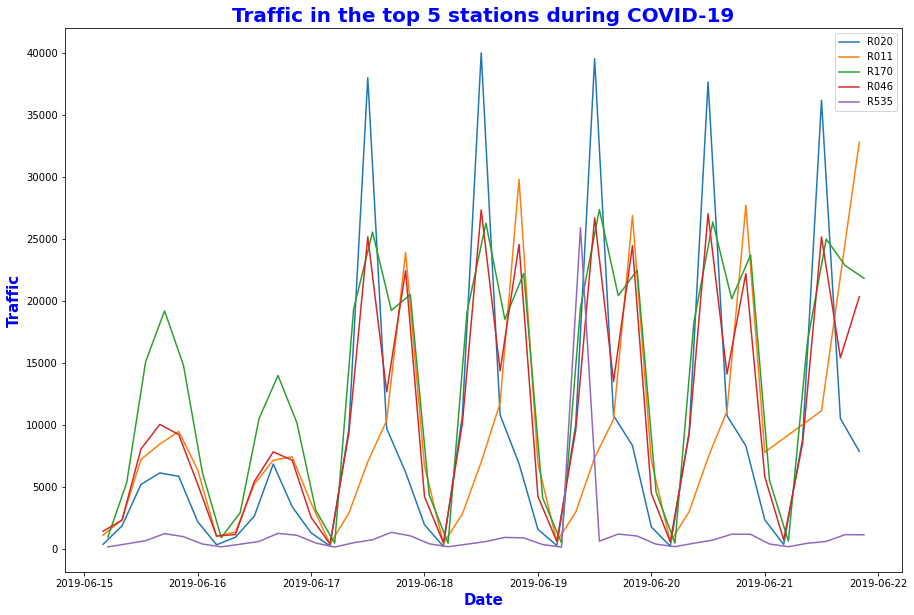

In [167]:
plt.figure(figsize=[15,10])
#plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top5units: 
    mask = (top['unit'] == i)
    top5_df = top[mask]
    plt.plot(top5_df.date_time, top5_df.delta_exits, label = top5_df.unit.iloc[0])
plt.legend()

plt.title('Traffic in the top 5 stations during COVID-19', fontsize=20, weight='bold',color='b')
plt.xlabel('Date', fontsize=15, weight='bold',color='b')
plt.ylabel('Traffic', fontsize=15, weight='bold',color='b')
plt.savefig('top5 stations traffic.png')

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top10units:
    mask = (unit_hourly['unit'] == i)
    top5_df = unit_hourly[mask].head(50)

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = unit_hourly['unit' ==i]
plt.legend()